# 프로젝트 2주차 과제- EDA 코드 제출
- 팀: 0 조
- 팀원: 김소망, 이사랑, 박믿음

## 1. 데이터 로드

In [4]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

In [5]:
CO2EMMISIONPATH = "data/co-emissions-per-capita.csv"
CARSALESPATH = "data/global-car-sales-by-key-markets-2005-2020.csv"
EVSALESPATH = "data/global-electric-car-sales-by-key-markets-2010-2020.csv"
RESTRICTIONURL = "https://en.wikipedia.org/wiki/Phase-out_of_fossil_fuel_vehicles"

In [6]:
#CO2 배출량 데이터 로드

co2Emission = pd.read_csv(CO2EMMISIONPATH)
co2Emission.head()

,Entity,Code,Year,Annual CO2 emissions (per capita)
0,Afghanistan,AFG,1949,0.0019
1,Afghanistan,AFG,1950,0.0109
2,Afghanistan,AFG,1951,0.0117
3,Afghanistan,AFG,1952,0.0115
4,Afghanistan,AFG,1953,0.0132


In [7]:
# 자동차 판매량 데이터 로드
# 전기차 판매량과 국가 이름을 맞춤

carSales = pd.read_csv(CARSALESPATH, index_col=0, skiprows=[0, 1, 2])\
    .drop(columns=["World (2020 H1)", "World (2020 H2)"])\
    .drop([2020])\
    [["China", "United States", "Japan"]]
carSales.head()

,China,United States,Japan
2005,4.940918,16.959718,4.249767
2006,6.259026,16.526294,4.005003
2007,7.589375,16.104484,3.718892
2008,8.151446,13.203105,3.493202
2009,12.458877,10.408939,3.225547


In [8]:
# 전기차 생산량 데이터 로드

evSales = pd.read_csv(EVSALESPATH, index_col=0, skiprows=[0, 1, 2])\
    .drop(columns=["World", "Market Share"])\
    .drop([2020])\
    .rename(columns={"USA": "United States"})\
    [["China", "United States", "Japan"]]
evSales.head()

,China,United States,Japan
2010,0.001551,0.001201,0.002442
2011,0.005403,0.017907,0.013471
2012,0.010422,0.054061,0.026924
2013,0.015891,0.097775,0.030943
2014,0.073890,0.120255,0.033332


In [9]:
req = requests.get(RESTRICTIONURL)
soup = BeautifulSoup(req.text)

In [10]:
selector = "table:nth-of-type(3) > tbody > tr"
components = soup.select(selector)

In [11]:
restriction = pd.DataFrame(columns=("City or Territory", "Country", "Announced", "Commences", "Scope", "Details"))

for component in components:
    if component.select_one("td") is None:
        continue

    def parse_wiki(text):
        text = re.sub("\s+$", "", text)
        text = re.sub("\[[0-9]+\]", "", text)
        return text

    def select_nth(i):
        return component.select_one("td:nth-of-type({})".format(i)).text

    restriction = restriction.append({
        "City or Territory": parse_wiki(select_nth(1)),
        "Country": parse_wiki(select_nth(2)),
        "Announced": parse_wiki(select_nth(3)),
        "Commences": parse_wiki(select_nth(4)),
        "Scope": parse_wiki(select_nth(5)),
        "Details": parse_wiki(select_nth(6))
    }, ignore_index=True)

restriction.head()

,City or Territory,Country,Announced,Commences,Scope,Details
0,Aachen,Germany,2018,2019,Diesel,"Older diesel vehicles (2019), unless pollution..."
1,Amsterdam,Netherlands,2019,2030,"Diesel, petrol","Euro I–III diesel cars (2020), non-electric bu..."
2,Antwerp,Belgium,2016,2017–2025,"Diesel, lpg, petrol","Euro I–II diesels and 0 petrol/lpg (2017), Eur..."
3,Arnhem,Netherlands,"201?, 2018",2014–2019,Diesel,"Euro I–III diesel trucks (2014), all Euro I–II..."
4,Athens,Greece,2016,2025,Diesel,All vehicles


## 2. 데이터 분석

In [12]:
import matplotlib.pyplot as plt

### 2.1. 주요 자동차 시장에서 전기자동차 점유율은 어떻게 변화해 왔을까?

In [13]:
COUNTRIES = list(evSales.columns)
YEARS = list(evSales.index)

# 전기자동차 점유율 계산

evShare = evSales.loc[YEARS, COUNTRIES] / carSales.loc[YEARS, COUNTRIES] * 100
evShare.head()

,China,United States,Japan
2010,0.009399,0.010390,0.068653
2011,0.031786,0.140619,0.456099
2012,0.058677,0.372981,1.306489
2013,0.078393,0.626742,1.503466
2014,0.339061,0.727766,1.569238


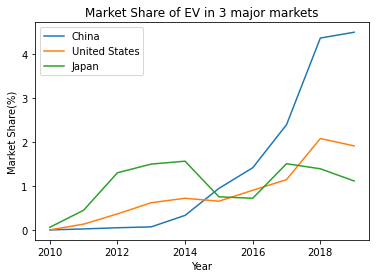

In [14]:
# 데이터 시각화

evShare.plot(y=COUNTRIES)
plt.title("Market Share of EV in 3 major markets")
plt.ylabel("Market Share(%)")
plt.xlabel("Year")
plt.show()

전체적으로 전기자동차의 점유을은 지난 10년간 모든 주요 시장에서 증가한 것을 확인할 수 있다. 그런데 그 중 일본에서만 유일하게 예외적으로 전기차 판매량이 계속 증가와 감소를 반복하며 변화하는 양상이 나타났다.
또한 전기자동차 점유율이 가장 높은 곳은 중국이었으며, 미국과 일본의 경우 비슷하게 나타났다.

### 2.2 4개의 주요 자동차 시장 지역에서는 CO2 배출량이 어떻게 나타날까?Em

In [15]:
co2EmissionGrouped = co2Emission.groupby(["Entity", "Year"]).sum()

In [16]:
def graphCo2(countries):
    ax = plt.subplot()

    for country in countries:
        co2EmissionCountry = co2EmissionGrouped.loc[(country, 1900): (country, 2019)]
        co2EmissionCountry.plot(y="Annual CO2 emissions (per capita)", ax=ax, xticks=range(0, 120 + 1, 20))

    ax.set_xticklabels(range(1900, 2020 + 1, 20))    
    plt.legend(countries)
    plt.title("Annual CO2 Emissions (per capita)")

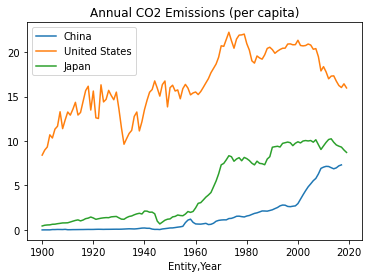

In [17]:
graphCo2(["China", "United States", "Japan"])

전기차 생산량이 늘어나고 있는 2010년 부근부터 미국, 일본은  CO2 배출량 곡선이 줄어든 것을 확인할 수 있다. 물론 전기차만 원인이라고 하기는 어렵겠지만, 전기차의 사용량이 늘어난 것도 분명 작용하였을 것이다.

### 2.3. 위 3개의 국가에서 실행되고 있는 자동차 관련 규제로는 무엇이 있을까?

In [18]:
restriction[restriction["Country"].isin(("United States", "China", "Japan"))]\
    .sort_values("Country")

,City or Territory,Country,Announced,Commences,Scope,Details
24,Hainan,China,2018,2030,"Diesel, petrol",All vehicles
13,California,United States,2020,2035,Net-emitting vehicles,All passenger vehicles and light-duty trucks.
30,Los Angeles,United States,2017,2030,"Diesel, petrol","All vehicles, electric buses by 2025"
32,Massachusetts,United States,2020,2035,"Diesel, petrol",Will set equivalent regulations to match Calif...
38,New York State,United States,2021,2035,Non-ZEV,New passenger cars and trucks and off-road veh...
39,New York City,United States,2020,2040,Non-electric vehicles,All vehicles owned or operated by New York City
48,Seattle,United States,2017,2030,"Diesel, petrol","All vehicles, electric buses by 2025"


미국의 경우 여러 도시에서 기존 자동차 관련 규제가 시행되고 있다. 그런데 규제가 크게 시행되고 있지 않은 중국이 더 전기차 거래량이 더 많은 것을 확인할 수 있다.

### 2.4. 전기차 관련 규제들이 발표 및 시행되기 시작한 것은 언제부터일까?

In [20]:
restriction.sort_values("Announced").head()

,City or Territory,Country,Announced,Commences,Scope,Details
52,Utrecht,Netherlands,"2013, 2020",2030,"Diesel, petrol","Pre-2001 diesel vehicles from 2015, pre-2004 d..."
47,Rotterdam,Netherlands,2015,2016,Diesel,Euro I–III diesel trucks (2016). Other bans we...
43,Paris,France,2016,2025,Diesel,All vehicles
2,Antwerp,Belgium,2016,2017–2025,"Diesel, lpg, petrol","Euro I–II diesels and 0 petrol/lpg (2017), Eur..."
4,Athens,Greece,2016,2025,Diesel,All vehicles


In [22]:
restriction.sort_values("Commences").head(10)

,City or Territory,Country,Announced,Commences,Scope,Details
37,Munich,Germany,20??,2012,"Diesel, petrol",Euro I–III diesel vehicles and Euro 0 petrol v...
36,Moscow,Russia,"20??, 2019",2013–20?,Non-electric,"Euro I–IV bus purchases (2013), all non-electr..."
18,Düsseldorf,Germany,20??,2014,"Diesel, petrol",Euro I–III diesel vehicles and Euro 0 petrol v...
3,Arnhem,Netherlands,"201?, 2018",2014–2019,Diesel,"Euro I–III diesel trucks (2014), all Euro I–II..."
47,Rotterdam,Netherlands,2015,2016,Diesel,Euro I–III diesel trucks (2016). Other bans we...
2,Antwerp,Belgium,2016,2017–2025,"Diesel, lpg, petrol","Euro I–II diesels and 0 petrol/lpg (2017), Eur..."
25,Hamburg,Germany,2018,2018,Diesel,"Euro I–V diesel vehicles in one street, older ..."
0,Aachen,Germany,2018,2019,Diesel,"Older diesel vehicles (2019), unless pollution..."
33,Mainz,Germany,2018,2019,"Diesel, petrol",Euro I–III diesel vehicles and Euro 0 petrol v...
21,Frankfurt,Germany,2018,2019,Diesel,Euro I–V diesel vehicles and Euro 1–2 petrol v...


In [24]:
restriction[restriction["Country"].isin(("United States", "China", "Japan"))]\
    .sort_values("Announced")

,City or Territory,Country,Announced,Commences,Scope,Details
30,Los Angeles,United States,2017,2030,"Diesel, petrol","All vehicles, electric buses by 2025"
48,Seattle,United States,2017,2030,"Diesel, petrol","All vehicles, electric buses by 2025"
24,Hainan,China,2018,2030,"Diesel, petrol",All vehicles
13,California,United States,2020,2035,Net-emitting vehicles,All passenger vehicles and light-duty trucks.
32,Massachusetts,United States,2020,2035,"Diesel, petrol",Will set equivalent regulations to match Calif...
39,New York City,United States,2020,2040,Non-electric vehicles,All vehicles owned or operated by New York City
38,New York State,United States,2021,2035,Non-ZEV,New passenger cars and trucks and off-road veh...


In [25]:
restriction[restriction["Country"].isin(("United States", "China", "Japan"))]\
    .sort_values("Commences")

,City or Territory,Country,Announced,Commences,Scope,Details
24,Hainan,China,2018,2030,"Diesel, petrol",All vehicles
30,Los Angeles,United States,2017,2030,"Diesel, petrol","All vehicles, electric buses by 2025"
48,Seattle,United States,2017,2030,"Diesel, petrol","All vehicles, electric buses by 2025"
13,California,United States,2020,2035,Net-emitting vehicles,All passenger vehicles and light-duty trucks.
32,Massachusetts,United States,2020,2035,"Diesel, petrol",Will set equivalent regulations to match Calif...
38,New York State,United States,2021,2035,Non-ZEV,New passenger cars and trucks and off-road veh...
39,New York City,United States,2020,2040,Non-electric vehicles,All vehicles owned or operated by New York City



이러한 규제 정책의 경우 발표된 것도 가장 오래된 것이 2015년으로, 그렇게 오래되지 않았다. 또 발표 후 실제로 시행되기 시작한 규제는 가장 2010년대 중반에도 있지만 대부분 2019년 가량 시작한다.

또 우리가 중점적으로 확인한 미국, 중국, 일본에서 발표된 규제는 가장 이른 것이 2017년으로 2년에서 3년 정도밖에 지나지 않았으며, 이 중 시행되기 시작한 것은 없다. 또 이때는 코로나의 영향으로 시장이 전체적으로 마비된 상황이었기 때문에 큰 영향을 끼치지 못한 것 같다